In [75]:
import numpy as np
import os


X, Y, Gamma = {}, {}, {}
vX, vY, vGamma = {}, {}, {}
novelX, novelY, novelGamma = [], [], []

data_path = '/home/yigit/phd/yigit_phd_thesis/cnmp/data/1_person_1_obs/'
for folder in os.listdir(data_path):
    folder_path = f'{data_path}{folder}'
    if folder == '10':
        novelX.append(np.load(f'{folder_path}/d_x.npy'))
        novelY.append(np.load(f'{folder_path}/d_y.npy'))
        novelGamma.append(np.load(f'{folder_path}/d_gamma.npy'))
    else:
        if os.path.isdir(folder_path):
            try:
                X.update({int(folder):np.load(f'{folder_path}/d_x.npy')})
                Y.update({int(folder):np.load(f'{folder_path}/d_y.npy')})
                Gamma.update({int(folder):np.load(f'{folder_path}/d_gamma.npy')})
                vX.update({int(folder):np.load(f'{folder_path}/v_d_x.npy')})
                vY.update({int(folder):np.load(f'{folder_path}/v_d_y.npy')})
                vGamma.update({int(folder):np.load(f'{folder_path}/v_d_gamma.npy')})
            except ValueError:
                pass

In [76]:
num_runs = len(vGamma)
print(num_runs)

10


We have *num_runs=10* runs in each dictionary. Next, we need to select the same amount of trajectories from each run to balance the data.

In [77]:
min_num_trajs = 100
min_id = -1

for i in range(num_runs):
    if len(Gamma[i]) < min_num_trajs:
        min_num_trajs = len(Gamma[i])
        min_id = i
print(f'{min_id}: {min_num_trajs}')

0: 17


Selecting *min_num_trajs=17* trajectory from X,Y,Gamma of each run

In [78]:
for i in range(num_runs):
    subset_ids = sorted(np.random.choice(len(Gamma[i]), min_num_trajs, replace=False))
    X.update({i:X[i][subset_ids]})
    Y.update({i:Y[i][subset_ids]})
    Gamma.update({i:Gamma[i][subset_ids]})

Doing the same for validation sets

In [79]:
v_min_num_trajs = 100
v_min_id = -1

for i in range(num_runs):
    if len(vGamma[i]) < v_min_num_trajs:
        v_min_num_trajs = len(vGamma[i])
        v_min_id = i
print(f'{v_min_id}: {v_min_num_trajs}')

for i in range(num_runs):
    subset_ids = sorted(np.random.choice(len(vGamma[i]), v_min_num_trajs, replace=False))
    vX.update({i:vX[i][subset_ids]})
    vY.update({i:vY[i][subset_ids]})
    vGamma.update({i:vGamma[i][subset_ids]})

0: 5


---
Normalizing lengths before saving

In [80]:
min_len_traj = 1000
v_min_len_traj = 1000
min_id = -1

for i in range(num_runs):
    for j in range(min_num_trajs):
        if len(X[i][j]) < min_len_traj:
            min_len_traj = len(X[i][j])
        
    for j in range(v_min_num_trajs):
        if len(vX[i][j]) < v_min_len_traj:
            v_min_len_traj = len(vX[i][j])
    
print(f'Demonstration min length: {min_len_traj}')
print(f'Validation min length: {v_min_len_traj}')

Demonstration min length: 305
Validation min length: 305


In [81]:
for i in range(num_runs):
    x, y, gamma = [], [], []
    for j in range(min_num_trajs):
        ids = sorted(np.random.choice(len(X[i][j]), min_len_traj, replace=False))
        x.append(X[i][j][ids])
        y.append(Y[i][j][ids])
        gamma.append(Gamma[i][j][ids])
    X.update({i:np.array(x)})
    Y.update({i:np.array(y)})
    Gamma.update({i:np.array(gamma)})
    
    v_x, v_y, v_gamma = [], [], []
    for j in range(v_min_num_trajs):
        ids = sorted(np.random.choice(len(vX[i][j]), v_min_len_traj, replace=False))
        v_x.append(vX[i][j][ids])
        v_y.append(vY[i][j][ids])
        v_gamma.append(vGamma[i][j][ids])
    vX.update({i:np.array(v_x)})
    vY.update({i:np.array(v_y)})
    vGamma.update({i:np.array(v_gamma)})

###

novelX = np.reshape(np.array(novelX), (np.shape(novelX)[1], np.shape(novelX)[2], np.shape(novelX)[3]))
novelY = np.reshape(np.array(novelY), (np.shape(novelY)[1], np.shape(novelY)[2], np.shape(novelY)[3]))
novelGamma = np.reshape(np.array(novelGamma), 
                        (np.shape(novelGamma)[1], np.shape(novelGamma)[2], np.shape(novelGamma)[3]))

x, y, gamma = [], [], []
for i in range(np.shape(novelX)[0]):
    ids = sorted(np.random.choice(np.shape(novelX)[1], v_min_len_traj, replace=False))
    x.append(novelX[i][ids])
    y.append(novelY[i][ids])
    gamma.append(novelGamma[i][ids])
    
novelX = np.array(x)
novelY = np.array(y)
novelGamma = np.array(gamma)

print(np.shape(novelX))

(25, 305, 2)


---
Combining and saving all. I'll create 3 versions: 
1. *combined_1* keeps one traj per run and no validation (for testing purposes)
2. *combined_all* keeps all trajectories.
3. *novel* keeps 11th run which will be used as the test data

In [82]:
x_dim, y_dim, gamma_dim = 2, 2, 2
xarr, yarr, gammaarr = [], [], []

for i in range(num_runs):
    rand_traj_id = np.random.choice(range(min_num_trajs), 1)
    xarr.append(X[i][rand_traj_id].reshape(min_len_traj, x_dim))
    yarr.append(Y[i][rand_traj_id].reshape(min_len_traj, y_dim))
    gammaarr.append(Gamma[i][rand_traj_id].reshape(min_len_traj, gamma_dim))

combined_1_path = f'{data_path}combined_1/'

xnp = np.array(xarr)
ynp = np.array(yarr)
gnp = np.array(gammaarr)

np.save(f'{combined_1_path}/d_x.npy', xnp)
np.save(f'{combined_1_path}/d_y.npy', ynp)
np.save(f'{combined_1_path}/d_gamma.npy', gnp)

###################################

novel_path = f'{data_path}novel/'
np.save(f'{novel_path}/d_x.npy', novelX)
np.save(f'{novel_path}/d_y.npy', novelY)
np.save(f'{novel_path}/d_gamma.npy', novelGamma)

###################################

xarr, yarr, gammaarr = [], [], []
vxarr, vyarr, vgammaarr = [], [], []

for i in range(num_runs):
    xarr.append(X[i])
    yarr.append(Y[i])
    gammaarr.append(Gamma[i])
    vxarr.append(vX[i])
    vyarr.append(vY[i])
    vgammaarr.append(vGamma[i])

print(np.shape(np.array(xarr)))
# (10, 17, 305, 2)
# This shape means for each of 10 runs, we have 17 trajectories of 305 steps where each step contains two dims
# Combining them means having shape (10*17, 305, 2)
    
combined_all_path = f'{data_path}combined_all/'
np.save(f'{combined_all_path}/d_x.npy', np.array(xarr).reshape(num_runs*min_num_trajs, min_len_traj, x_dim))
np.save(f'{combined_all_path}/d_y.npy', np.array(yarr).reshape(num_runs*min_num_trajs, min_len_traj, y_dim))
np.save(f'{combined_all_path}/d_gamma.npy', np.array(gammaarr).reshape(num_runs*min_num_trajs, min_len_traj, gamma_dim))
np.save(f'{combined_all_path}/v_d_x.npy', np.array(vxarr).reshape(num_runs*v_min_num_trajs, v_min_len_traj, x_dim))
np.save(f'{combined_all_path}/v_d_y.npy', np.array(vyarr).reshape(num_runs*v_min_num_trajs, v_min_len_traj, y_dim))
np.save(f'{combined_all_path}/v_d_gamma.npy', np.array(vgammaarr).reshape(num_runs*v_min_num_trajs, v_min_len_traj, gamma_dim))

(10, 17, 305, 2)


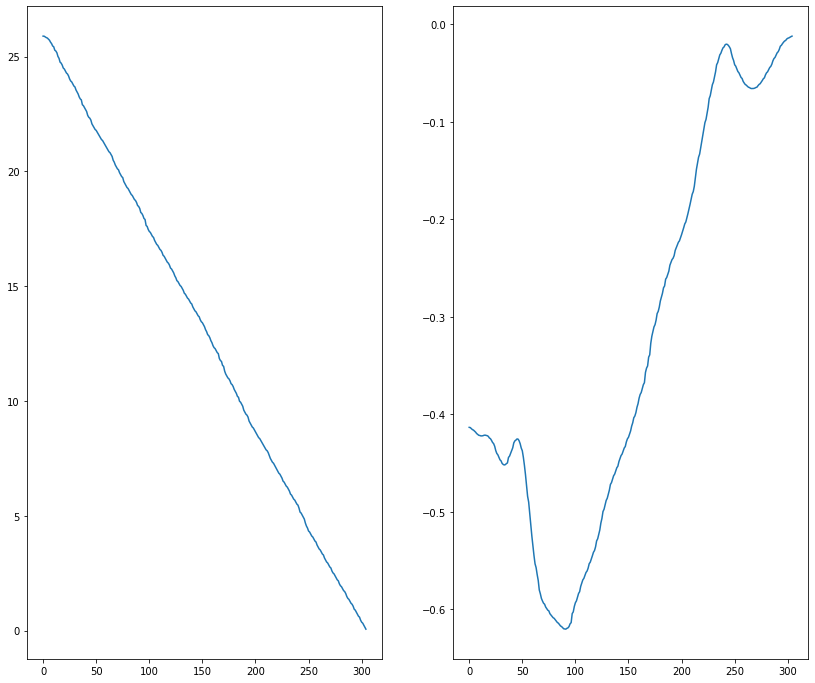

In [83]:
# check if the data look reasonable
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 12]
fig, axs = plt.subplots(1, 2)
axs[0].plot(range(305), xnp[1, :, 0])
axs[1].plot(range(305), xnp[1, :, 1])